# Bayes Estimator

$$P(\theta|X) = \frac{P(X|\theta) P(\theta)}{P(X)} $$


$P(X|\theta)$: Likelihood Function

$P(X)$: $\int P(X|\theta) \cdot P(\theta) \, d\theta$

$P(\theta)$: Prior

- Prior bleibt konstant und müsste nur einmal ausgerechnet werden
- muss ich normalisieren, nee oder?

1. Prior ausrechnen und speichern
2. Likelihood * Prior rechnen -> Funktion minimieren

In [ ]:
from adaptivetesting.math.estimators._functions.__estimators import likelihood
import numpy as np
from scipy.integrate import quad, simpson
from scipy.optimize import minimize_scalar, OptimizeResult
from scipy.stats import norm


In [ ]:
class Prior:
    def __init__(self, density_func, *params):
        self.density_func = density_func
        self.params = params

        self.theta = np.linspace(-10, 10, 1000)
        self.x = self.density_func(self.theta, *self.params)

    def pdf(self, x):
        interpolated_value = np.interp(x, self.theta, self.x)
        return interpolated_value
# needs a density function and the parameters
# densitiy is initialized with the parameters and only calculated once

In [17]:
def maximize_posterior(a: np.ndarray, b: np.ndarray, c: np.ndarray, d: np.ndarray, response_pattern: np.ndarray, prior: Prior):
 
    posterior = lambda mu: likelihood(mu, a, b, c, d, response_pattern) * prior.pdf(mu)
    result: OptimizeResult = minimize_scalar(lambda mu: -posterior(mu), bounds=(-10, 10), method='bounded')
    
    if not result.success:
        raise Exception(f"Optimization failed: {result.message}")
    else:
        return result.x  

In [18]:
a = np.array([0.3,-4,4])
b = np.array([1,1,1])
c = np.array([0,0,0])
d = np.array([1,1,1])
response_pattern = np.array([1,0,1])

prior = Prior(norm.pdf, 0, 1)

In [19]:
maximize_posterior(a, b, c, d, response_pattern, prior)

Array(-6.733596, dtype=float32)

Das funktioniert.

Neues Problem: Posterior als Prior für nächste Berechnung oder macht man das nicht?

C:\Users\Jonas Engicht\AppData\Local\Temp\ipykernel_7372\1266741833.py:7: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  normalization_constant, _ = quad(posterior, -10, 10)


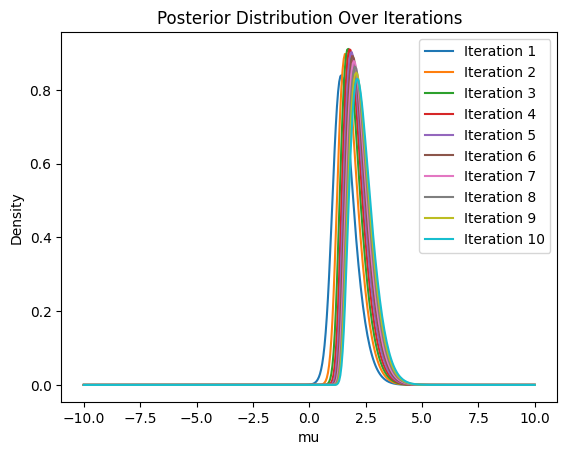

In [15]:
import matplotlib.pyplot as plt

def update_prior_with_posterior(a: np.ndarray, b: np.ndarray, c: np.ndarray, d: np.ndarray, response_pattern: np.ndarray, prior: Prior):
    posterior = lambda mu: likelihood(mu, a, b, c, d, response_pattern) * prior.pdf(mu)
    
    # Normalize the posterior to get a proper probability density function
    normalization_constant, _ = quad(posterior, -10, 10)
    normalized_posterior = lambda mu: posterior(mu) / normalization_constant
    
    # Create a new Prior object with the normalized posterior as the density function
    new_prior = Prior(normalized_posterior)
    
    return new_prior

# Example of continuous updating
prior = Prior(norm.pdf, 0, 1)  # Initial prior

x = np.linspace(-10, 10, 400)

# Update the prior with new data
for _ in range(10):  # Assume we update 5 times for demonstration
    new_prior = update_prior_with_posterior(a, b, c, d, response_pattern, prior)
    prior = new_prior  # Set the new prior for the next iteration

    y = np.array([prior.pdf(val) for val in x])

    # Plot the updated prior
    plt.plot(x, y, label=f'Iteration {_+1}')

plt.title('Posterior Distribution Over Iterations')
plt.xlabel('mu')
plt.ylabel('Density')
plt.legend()
plt.show()

MÖGLICHKEIT

Prior mit large array aber vorberechnet für bestimmte Werte, die dann zurückgegeben werden (Interpolation)

nach estimation, prior neu ausrechnen und neu speichern